# 1 - Бинарная классификация на примере детекции фрода на кредитных картах
У вас есть информация о множесте транзакций. Нужно научиться предсказывать, какие из них мошеннические, а какие нет.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, plot_roc_curve, roc_curve, auc
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn import preprocessing
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from tqdm.notebook import tqdm
from collections import Counter
from plotnine import ggplot
warnings.filterwarnings("ignore")
plt.style.use('bmh')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')

In [ ]:
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [ ]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Пропусков в данных нет

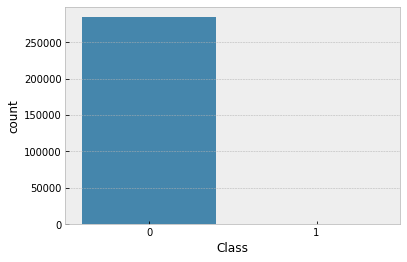

In [ ]:
sns.countplot(x='Class', data=df);

По гистограмме мы видим явную несбалансированность классов, мошеннических транзакций много меньше обычных

Колонки V1-V28 уже преобразованы с помощью PCA, теперь надо посмотреть на распределение колонок время ('Time') и сумму транзакций ('Amount')

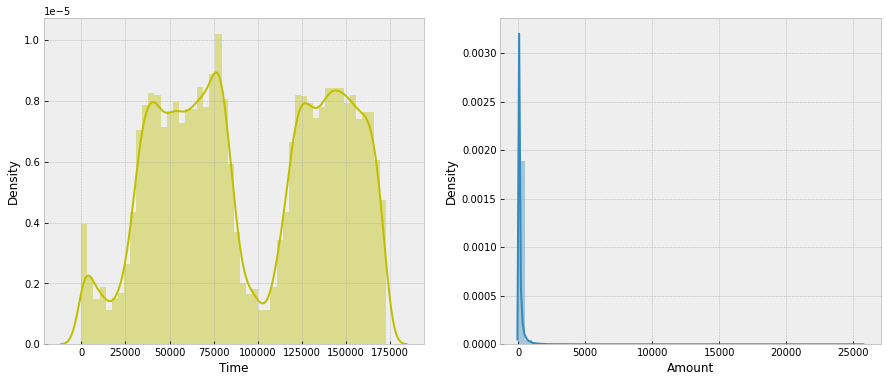

In [ ]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1 = sns.distplot(df['Time'], ax=ax1, color='y')
ax2 = sns.distplot(df['Amount'], ax=ax2)

In [ ]:
rs = RobustScaler()
df['New_Amount'] = rs.fit_transform(df['Amount'].values.reshape(-1,1))
df['New_Time'] = rs.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

### Обучим несколько моделей, посмотрим на метрики.

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### LogisticRegression

In [ ]:
def metrics(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'precision: {precision_score(y_test, y_pred)}')
    print(f'recall: {recall_score(y_test, y_pred)}')
    print(f'f1-score: {f1_score(y_test, y_pred)}')
    print(f'roc_auc: {roc_auc_score(y_test, y_pred)}')
    return model

accuracy: 0.9991748885221726
precision: 0.8311688311688312
recall: 0.6530612244897959
f1-score: 0.7314285714285713
roc_auc: 0.8264163044227257


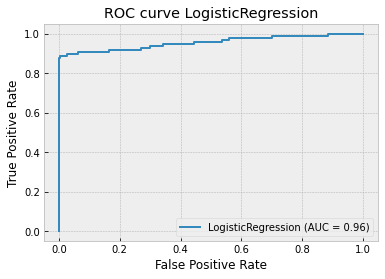

In [ ]:
plot_roc_curve(metrics(LogisticRegression(), X_train, X_test, y_train, y_test), X_test, y_test)
plt.title('ROC curve LogisticRegression');

#### KNeighborsClassifier

accuracy: 0.9995084442259752
precision: 0.9166666666666666
recall: 0.7857142857142857
f1-score: 0.8461538461538461
roc_auc: 0.8927955924913578


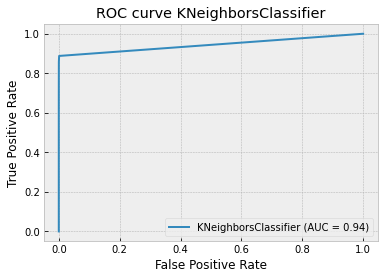

In [ ]:
plot_roc_curve(metrics(KNeighborsClassifier(), X_train, X_test, y_train, y_test), X_test, y_test)
plt.title('ROC curve KNeighborsClassifier');

#### Constant

In [ ]:
print('Const')
y_pred = np.zeros(len(X_test))
print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred)}')
print(f'recall: {recall_score(y_test, y_pred)}')
print(f'f1-score: {f1_score(y_test, y_pred)}')
print(f'roc_auc: {roc_auc_score(y_test, y_pred)}')

Const
accuracy: 0.9982795547909132
precision: 0.0
recall: 0.0
f1-score: 0.0
roc_auc: 0.5


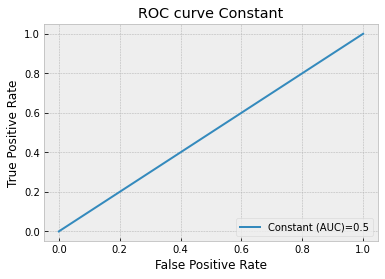

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc = np.trapz(fpr, tpr)
plt.plot(fpr, tpr, label="Constant (AUC)="+str(auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve Constant")
plt.legend(loc=4);

#### RandomForest

accuracy: 0.9996137776061234
precision: 0.9418604651162791
recall: 0.826530612244898
f1-score: 0.8804347826086957
roc_auc: 0.9132213415754596


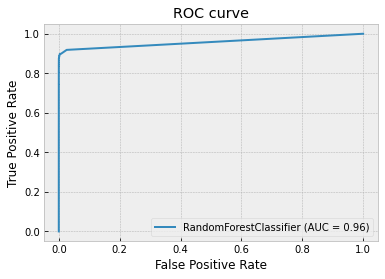

In [ ]:
plot_roc_curve(metrics(RandomForestClassifier(), X_train, X_test, y_train, y_test), X_test, y_test)
plt.title('ROC curve');

### Выбрать одну метрику, которую будем максимизировать

Представьте, что вы решаете задачу автоматического поиска мошеннических транзакций, чтобы ваш робот автоматически банил пользователей, который их осуществляют.

Обоснуйте свой выбор.

**Ответ:** Буду максимизировать f1-score.

**Пояснение**: Давайте разбираться на примерах. **1.** Почему я не выбрал **accuracy**? В этом датасете очень сильная несбалансированность классов, мошеннических транзакций мало, и поэтому **accuracy** близка к 1, но это не значит, что эта метрика хорошо работает, она просто хорошо показывает немошеннические транзакции. **2.** Почему я не выбрал **precision**? Допустим мы будем максимизировать **precision** для нашего алгоритма и получим, что количество предсказанного алгоритмом класса близко к количеству элементов реального класса, вроде бы все хорошо, метрика **precision** близка к единице, но не тут то было! Пусть алгоритм предсказал 5 транзакций мошенническими и все они реально оказались таковыми, но из этого не следует, что все отлично, ведь по-настоящему может быть, что таких транзакций, например, 100, да, мы предсказали 5 верно, но 95 даже не заметили, и мошенники останутся безнаказанными, это очень плохо! **3.** Почему я не выбрал только **recall**? Допустим у нас всего мошеннических транзакций 5, и наш алгоритм предсказал 100 мошеннических транзакций, среди которых затесались те самые 5 мошеннических, вроде хорошо, **recall** равен 1, но попутно мы нахватали обычных 95 пользователей, которых просто так заблокируем, это тоже очень плохо! Поэтому будем максимизировать среднее гармоническое этих метрик - **f1-score**

In [ ]:
def f1score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

### Перебор гиперпараметров разных моделей

In [ ]:
def model_fit(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model

#### LogisticRegression

Попробуем посмотреть на взаимодействие переменных и подобавлять новые фичи в датасет

In [ ]:
def model_improve(model, X, y):
    column_list = X.columns
    interactions = list(combinations(column_list, 2))

    interaction_dict = {}
    for i in tqdm(range(len(interactions))):
        X_new = X
        X_new['NEW'] = X_new[interactions[i][0]] * X_new[interactions[i][1]]
        model.fit(X_new, y)
        interaction_dict[model.score(X_new, y)] = interactions[i]
    
    top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
    for interaction in top_5:
        print(interaction_dict[interaction])

Топ-5 лучших взаимодействий фич для LogisticRegression

In [ ]:
model_improve(LogisticRegression(), X, y)


('V11', 'V17')
('V11', 'V12')
('V12', 'V17')
('V12', 'V16')
('V12', 'V14')


Перебрал некоторые пары из них и добавил 4 новые фичи в датасет

In [ ]:
X_new1 = X
X_new1['V11_V17'] = X_new1['V11'] * X_new1['V17']
X_new1['V11_V12'] = X_new1['V11'] * X_new1['V12']
X_new1['V12_V17'] = X_new1['V12'] * X_new1['V17']
X_new1['V12_V16'] = X_new1['V12'] * X_new1['V16']

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_new1, y, test_size=0.2, random_state=42)

In [ ]:
f1score(LogisticRegression(), X_train1, X_test1, y_train1, y_test1)

0.7909604519774011

Добавление фич улучшило результат с 0.695 до **0.79**

Теперь попробуем подобрать лучшие гиперпараметры для Логистической регрессии!

In [ ]:
def best_params_log(X_train1, y_train1, scoring, solver=['lbfgs']):
    parameters = {
                'penalty' : ['l1','l2'], 
                'class_weight' : ['balanced', None], 
                'C' : [0.1, 1, 5, 10],
                'max_iter': [10, 100, 500],
                'solver': solver
                }
    log_cv = GridSearchCV(LogisticRegression(), parameters, cv=5, scoring=scoring)
    log_cv.fit(X_train1, y_train1)

    best_parameters = log_cv.best_params_
    print('The best parameters for using this model is', best_parameters)

In [ ]:
best_params_log(X_train1, y_train1, scoring='f1')

The best parameters for using this model is {'C': 10, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


In [ ]:
log_best = LogisticRegression(C = 10,
                              penalty ='l2', 
                              class_weight = None,
                              max_iter = 100)

In [ ]:
f1score(log_best, X_train1, X_test1, y_train1, y_test1)

0.8

Перебор гиперпараметров немного помог!

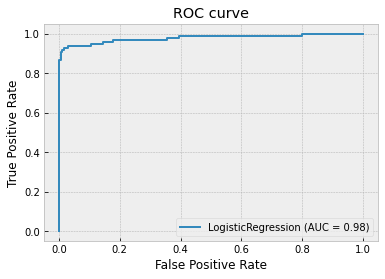

In [ ]:
plot_roc_curve(model_fit(log_best, X_train1, X_test1, y_train1, y_test1), X_test1, y_test1)
plt.title('ROC curve');

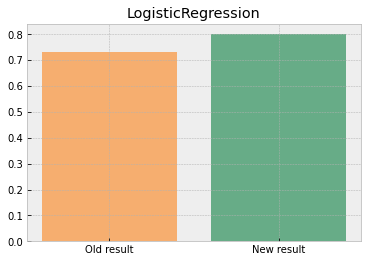

In [ ]:
log_reg = ['Old result', 'New result']
log_reg_result = [f1score(LogisticRegression(), X_train, X_test, y_train, y_test), f1score(log_best, X_train1, X_test1, y_train1, y_test1)]
log_reg_colors = ["#F6AE6F", "#67AC87"]
plt.title('LogisticRegression')
plt.bar(log_reg, log_reg_result, color=log_reg_colors);

**Вывод**: Метрику f1-score удалось заметно улучшить с 0.73 до **0.8**

#### KNeighborsClassifier

In [ ]:
param_grid = {
            'n_neighbors': [5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['minkowski', 'euclidean', 'manhattan']
            }

knn_cv = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = param_grid, cv=5, scoring = 'f1', verbose = 10, n_jobs = -1)
knn_cv.fit(X_train, y_train)

best_parameters = knn_cv.best_params_
print("The best parameters for using this model is", best_parameters)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 45.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 59.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 79.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 96.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 123.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 166.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 240.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 287.8min finished


The best parameters for using this model is {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [ ]:
knn_best = KNeighborsClassifier(n_neighbors=5, metric='manhattan', weights='distance')
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)
f1_score(y_test, y_pred)

0.8555555555555556

Перебор гиперпараметров улучшил качество метрики!

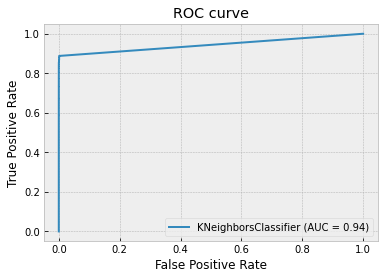

In [ ]:
plot_roc_curve(model_fit(knn_best, X_train, X_test, y_train, y_test), X_test, y_test)
plt.title('ROC curve');

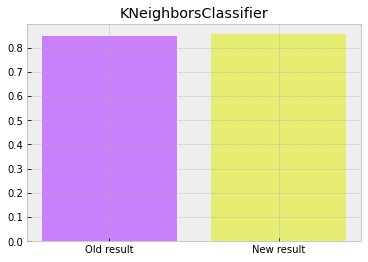

In [ ]:
knn = ['Old result', 'New result']
knn_result = [f1score(KNeighborsClassifier(), X_train, X_test, y_train, y_test), f1_score(y_test, y_pred)]
knn_colors = ["#C980FA", "#E5ED73"]
plt.title('KNeighborsClassifier')
plt.bar(knn, knn_result, color=knn_colors);

**Вывод**: реультат KNN удалось улучшить перебором гиперпараметров, c 0.846 до **0.86**, добавление новых фич и передача модели в функцию model_improve занимает необъятно дорогое количество времени (tqdm выдало более суток), поэтому для KNN это не использовал

#### RandomForest

In [ ]:
X2 = df.drop('Class', axis=1)
y2 = df['Class']

In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X2, y2, test_size=0.2, stratify=y2, random_state=42)

In [ ]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train3, y_train3)
y_pred3 = rf.predict(X_test3)
f1_score(y_test3, y_pred3)

0.8743169398907105

Визуализируем важность каждого признака в датафрейме

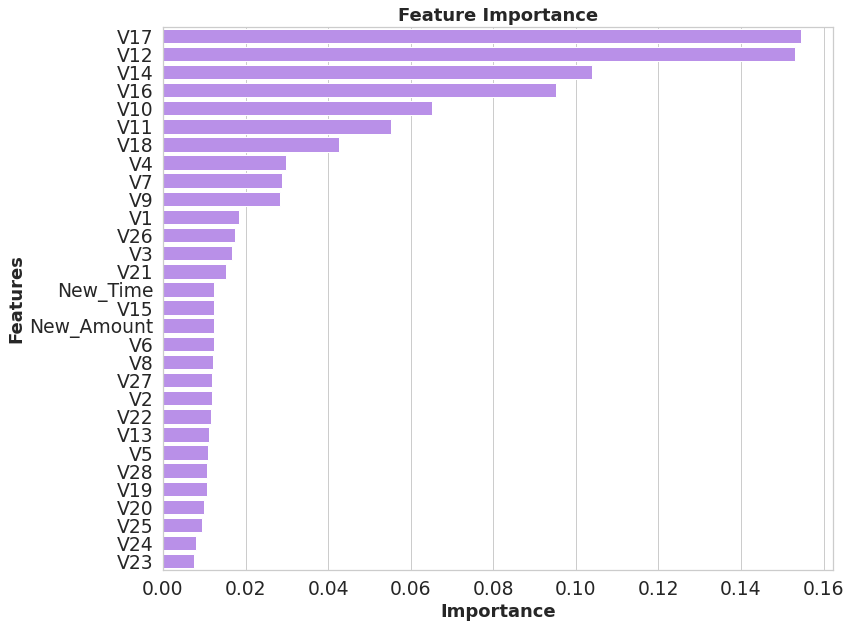

In [ ]:
feats = {}
for feature, importance in zip(X2.columns, rf.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(12,10)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color="#B881F7")
plt.xlabel('Importance', fontsize=18, weight = 'bold')
plt.ylabel('Features', fontsize=18, weight = 'bold')
plt.title('Feature Importance', fontsize=18, weight = 'bold');

Попробуем выкинуть признаки, которые оказывают малое влияние в нашем датафрейме, оставим около 95% от влияния всех признаков на наши данные

In [ ]:
sum = 0
for i in range(len(importances['Gini-Importance'])):
    if sum >= 0.95:
        break
    sum += importances['Gini-Importance'][i]
    k = i
print(k)

24


In [ ]:
df_rf = df.drop(['New_Amount', 'V22', 'V28', 'V25', 'V24', 'V23'], axis=1)

In [ ]:
X_rf = df_rf.drop('Class', axis=1)
y_rf = df_rf['Class']

In [ ]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_rf, y_rf, test_size=0.2, stratify=y_rf, random_state=42)

In [ ]:
rf_new = RandomForestClassifier(n_jobs=-1)
rf_new.fit(X_train4, y_train4)
y_pred4 = rf_new.predict(X_test4)
f1_score(y_test4, y_pred4)

0.8743169398907105

Попробовал уменьшить размерность, чтобы быстрее перебирались гиперпараметры 

In [ ]:
param_grid = {
            'n_estimators': [200, 500],
            'max_features': [2, 3],
            'min_samples_leaf': [2, 4],
            'min_samples_split': [1, 5]
            }

rf_cv = GridSearchCV(estimator = rf_new, param_grid = param_grid, scoring = 'f1', verbose = 10, n_jobs = -1)
rf_cv.fit(X_train4, y_train4)

best_parameters = rf_cv.best_params_
print("The best parameters for using this model is", best_parameters)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 51.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 60.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 92.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 106.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 160.5min finished


The best parameters for using this model is {'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
rf_best = RandomForestClassifier(n_estimators=200, max_features=3, min_samples_leaf=2, min_samples_split=5, n_jobs=-1)
rf_best.fit(X_train4, y_train4)
y_pred4 = rf_best.predict(X_test4)
f1_score(y_test4, y_pred4)

0.8729281767955801

Как видно перебор небольшого количества гиперпараметров RandomForest не помог, результат ухудшился

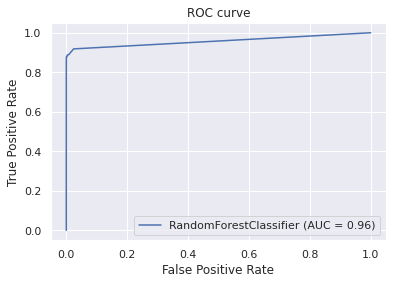

In [ ]:
plt.style.use('bmh')
sns.set()
plot_roc_curve(model_fit(rf_new, X_train4, X_test4, y_train4, y_test4), X_test4, y_test4)
plt.title('ROC curve');

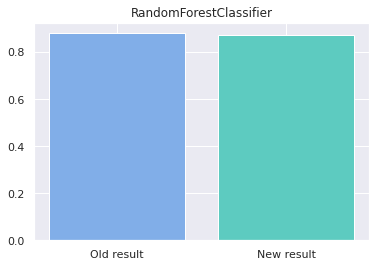

In [ ]:
rand_for = ['Old result', 'New result']
rand_for_result = [f1score(RandomForestClassifier(), X_train, X_test, y_train, y_test), f1_score(y_test4, y_pred4)]
rand_for_colors = ["#81AEE8", "#5DCBC0"]
plt.title('RandomForestClassifier')
sns.set()
plt.bar(rand_for, rand_for_result, color=rand_for_colors);

**Вывод**: преобразованиями метрику f1_score улучшить не удалось, лучший разультат остался **0.88**

### **Вывод**: Наилучшего качество метрики удалось достичь у RandomForest - 0.88, что касается улучшений, в сторону лучшего результата удалось вывести модели LogisticRegression и KNeighborsClassifier

# 2 - Небинарная классификация на датасете про здоровье плода при рождении

Про датасет: Классифицировать здоровье плода с целью предотвращения детской и материнской смертности.

Датасет разделен на 3 класса:
1.0 - Обычный,
2.0 - Подозрение,
3.0 - Патология

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/fetal_health.csv')

In [ ]:
data.head(3)

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


Во всех колонках count=2126.0 => Пропусков в данных нет

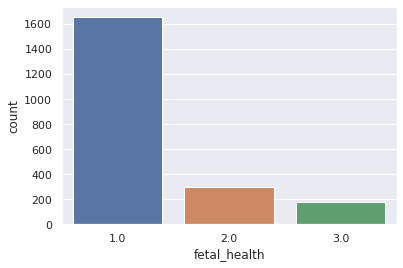

In [ ]:
sns.set()
sns.countplot(x='fetal_health', data=data);

По гистограмме видно, что здоровый плод встречаеся чем плод с отклонениями

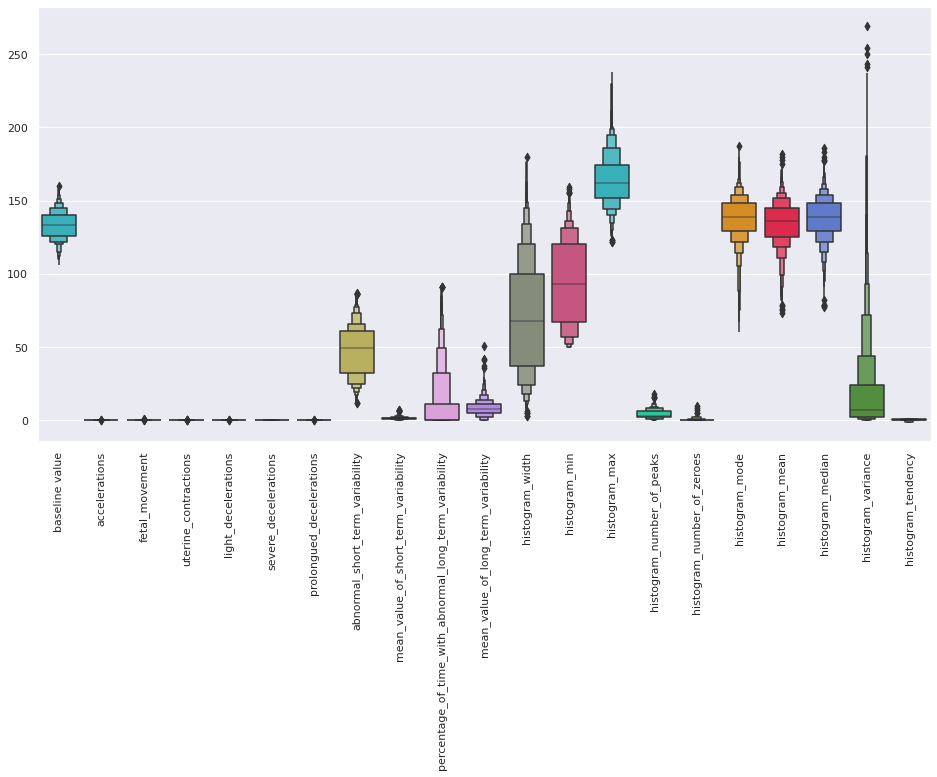

In [ ]:
sns.set()
colors =["#23C3CE","#13DFA8","#EFEF19", "#F29306", "#F90D3C", "#4C72DB", "#4B9A33", "#C8BC50", "#6C3B72", "#E397E3", "#AE7AF2", "#869077", "#D7447A"]
plt.figure(figsize=(16,8))
sns.boxenplot(data=data.drop('fetal_health', axis=1), palette=colors)
plt.xticks(rotation=90);

### Обучим несколько моделей, посмотрим на метрики.

In [ ]:
def accuracy(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [ ]:
def precision_recall(model, average):
    model.fit(X_train4, y_train4)
    y_pred4 = model.predict(X_test4)
    print(f'precision - {average}: {precision_score(y_test4, y_pred4, average=average)}')
    print(f'recall - {average}: {recall_score(y_test4, y_pred4, average=average)}')
    print(f'f1-score - {average}: {f1_score(y_test4, y_pred4, average=average)}')

In [ ]:
def result_prec_rec(model, precision_recall):
    precision_recall(model, 'micro')
    print('--------------------------------------')
    precision_recall(model, 'macro')
    print('--------------------------------------')
    precision_recall(model, 'weighted')


In [ ]:
def plot_metrics(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision_colors = ["#8DCDF8", "#BFE5FE", "#4BA2DB"]
    precision = ['micro', 'macro', 'weighted']
    precision_result = [precision_score(y_test, y_pred, average='micro'), precision_score(y_test, y_pred, average='macro'), precision_score(y_test, y_pred, average='weighted')]
    recall_colors = ["#6BC454", "#8DE278", "#6BC454"]
    recall = ['micro', 'macro', 'weighted']
    recall_result = [recall_score(y_test, y_pred, average='micro'), recall_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='weighted')]
    f1_colors = ["#C974DF", "#E59DF7", "#AE55C4"]
    f1 = ['micro', 'macro', 'weighted']
    f1_result = [f1_score(y_test, y_pred, average='micro'), f1_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='weighted')]
    fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    ax1.bar(precision,precision_result, color=precision_colors)
    ax1.set_title(f'precision')
    ax2.bar(recall,recall_result, color=recall_colors)
    ax2.set_title(f'recall')
    ax3.bar(f1,f1_result, color=f1_colors)
    ax3.set_title(f'f1-score');

In [ ]:
X2 = data.drop('fetal_health', axis=1)
y2 = data['fetal_health']

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [ ]:
print(f'LogisticRegression accuracy without changes dataset: {accuracy(LogisticRegression(), X_tr, X_te, y_tr, y_te)}')

LogisticRegression accuracy without changes dataset: 0.8685446009389671


In [ ]:
print(f'KNeighborsClassifier accuracy without changes dataset: {accuracy(KNeighborsClassifier(), X_tr, X_te, y_tr, y_te)}')

KNeighborsClassifier accuracy without changes dataset: 0.8732394366197183


In [ ]:
print(f'RandomForestClassifier accuracy without changes dataset: {accuracy(RandomForestClassifier(random_state=42), X_tr, X_te, y_tr, y_te)}')

RandomForestClassifier accuracy without changes dataset: 0.9460093896713615


Делаю стандартизацию данных

In [ ]:
columns = X2.columns
d = preprocessing.scale(X2)
X2 = pd.DataFrame(d, columns=columns)
X2.head(3)

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
0,-1.352220,-0.822388,-0.20321,-1.482465,-0.638438,-0.057476,-0.268754,1.513190,-0.943095,1.802542,-1.028560,-0.165507,-1.068562,-2.119592,-0.701397,-0.458444,-1.065614,0.153270,-1.181642,1.870569,1.112980
1,-0.132526,0.730133,-0.20321,0.554627,0.375243,-0.057476,-0.268754,-1.744751,0.868841,-0.535361,0.393176,1.529124,-0.865539,1.893794,0.655137,0.958201,0.216638,0.089126,0.132038,-0.234998,-0.524526
2,-0.030884,-0.046128,-0.20321,1.233657,0.375243,-0.057476,-0.268754,-1.802928,0.868841,-0.535361,0.926327,1.529124,-0.865539,1.893794,0.316003,0.958201,0.216638,0.024982,-0.006244,-0.200481,-0.524526


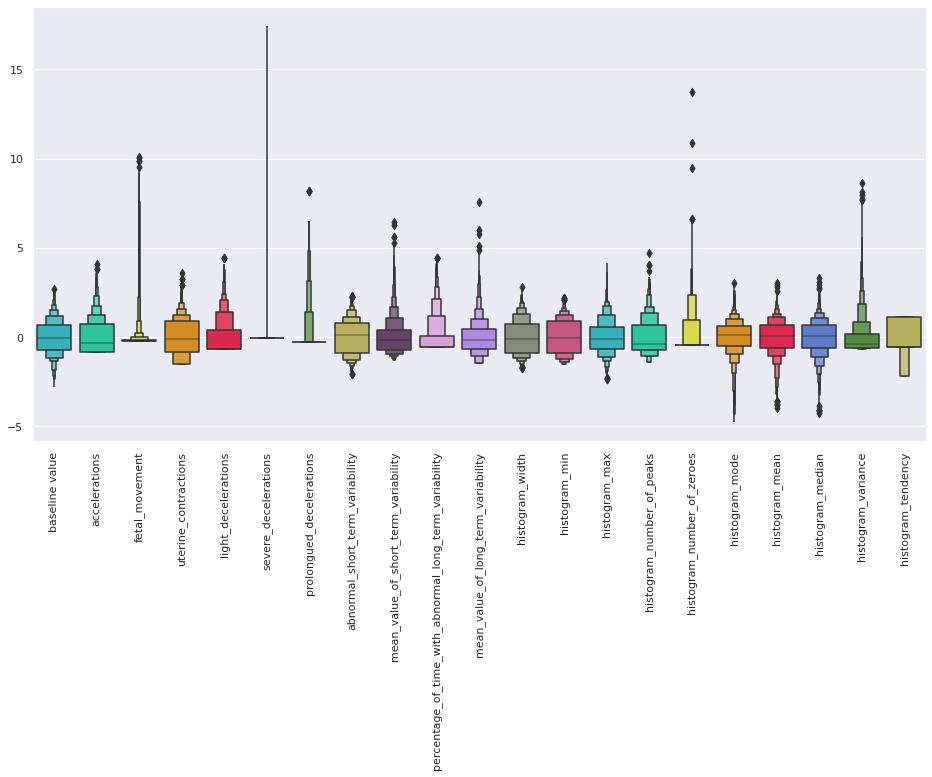

In [ ]:
colors =["#23C3CE","#13DFA8","#EFEF19", "#F29306", "#F90D3C", "#4C72DB", "#4B9A33", "#C8BC50", "#6C3B72", "#E397E3", "#AE7AF2", "#869077", "#D7447A"]
plt.figure(figsize=(16,8))
sns.boxenplot(data=X2, palette=colors)
plt.xticks(rotation=90);

In [ ]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X2, y2, test_size=0.2, random_state=42)

#### LogisticRegression

In [ ]:
accuracy(LogisticRegression(), X_train4, X_test4, y_train4, y_test4)

0.8779342723004695

In [ ]:
result_prec_rec(LogisticRegression(), precision_recall)

precision - micro: 0.8779342723004695
recall - micro: 0.8779342723004695
f1-score - micro: 0.8779342723004695
--------------------------------------
precision - macro: 0.7678932011258296
recall - macro: 0.7777265411963686
f1-score - macro: 0.7727228715149653
--------------------------------------
precision - weighted: 0.8791433134141954
recall - weighted: 0.8779342723004695
f1-score - weighted: 0.878511822006233


LogisticRegression


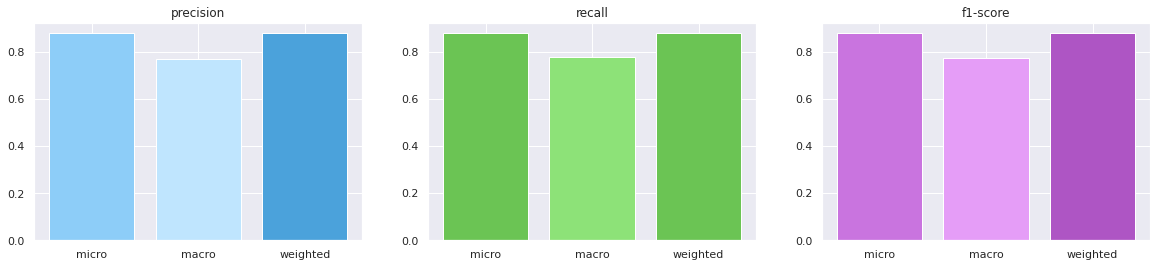

In [ ]:
print('LogisticRegression')
plot_metrics(LogisticRegression(), X_train4, X_test4, y_train4, y_test4)

#### KNeighborsClassifier

In [ ]:
accuracy(KNeighborsClassifier(), X_train4, X_test4, y_train4, y_test4)

0.9154929577464789

In [ ]:
result_prec_rec(KNeighborsClassifier(), precision_recall)

precision - micro: 0.9154929577464789
recall - micro: 0.9154929577464789
f1-score - micro: 0.9154929577464789
--------------------------------------
precision - macro: 0.8474631885484598
recall - macro: 0.8063645542093818
f1-score - macro: 0.8249521650222912
--------------------------------------
precision - weighted: 0.9121441251586464
recall - weighted: 0.9154929577464789
f1-score - weighted: 0.9127943115001805


KNeighborsClassifier


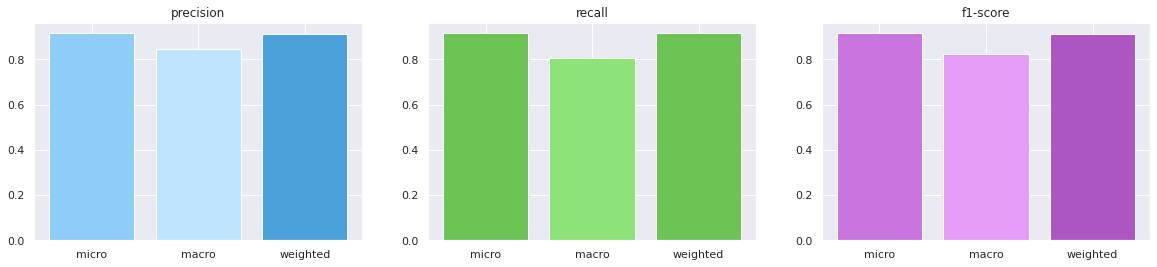

In [ ]:
print('KNeighborsClassifier')
plot_metrics(KNeighborsClassifier(), X_train4, X_test4, y_train4, y_test4)

#### Constant

In [ ]:
Counter(y_train4)

Counter({1.0: 1322, 2.0: 231, 3.0: 147})

In [ ]:
y_pred_const = np.ones(len(X_test4))
accuracy_score(y_test4, y_pred_const)

0.7816901408450704

In [ ]:
def precision_recall_const(average):
    y_pred_const = np.ones(len(X_test4))
    print(f'precision - {average}: {precision_score(y_test4, y_pred_const, average=average)}')
    print(f'recall - {average}: {recall_score(y_test4, y_pred_const, average=average)}')
    print(f'f1-score - {average}: {f1_score(y_test4, y_pred_const, average=average)}')

def result_prec_rec_const(precision_recall):
    precision_recall_const('micro')
    print('--------------------------------------')
    precision_recall_const('macro')
    print('--------------------------------------')
    precision_recall_const('weighted')

result_prec_rec_const(precision_recall)

precision - micro: 0.7816901408450704
recall - micro: 0.7816901408450704
f1-score - micro: 0.7816901408450704
--------------------------------------
precision - macro: 0.2605633802816901
recall - macro: 0.3333333333333333
f1-score - macro: 0.2924901185770751
--------------------------------------
precision - weighted: 0.611039476294386
recall - weighted: 0.7816901408450704
f1-score - weighted: 0.6859099259589155


Constant


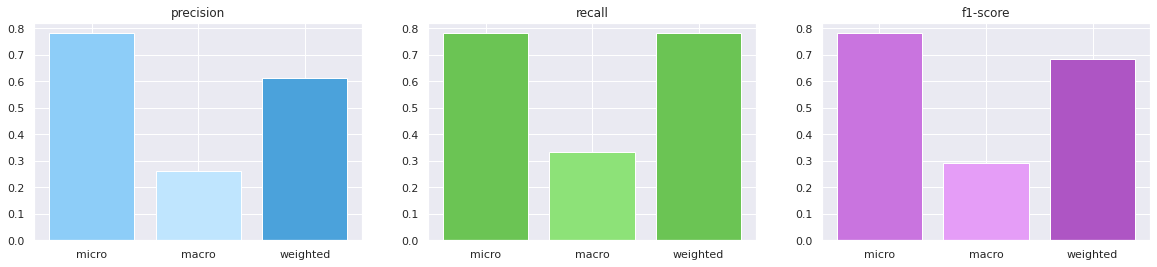

In [ ]:
print('Constant')
precision_colors = ["#8DCDF8", "#BFE5FE", "#4BA2DB"]
precision = ['micro', 'macro', 'weighted']
precision_result = [precision_score(y_test4, y_pred_const, average='micro'), precision_score(y_test4, y_pred_const, average='macro'), precision_score(y_test4, y_pred_const, average='weighted')]
recall_colors = ["#6BC454", "#8DE278", "#6BC454"]
recall = ['micro', 'macro', 'weighted']
recall_result = [recall_score(y_test4, y_pred_const, average='micro'), recall_score(y_test4, y_pred_const, average='macro'), recall_score(y_test4, y_pred_const, average='weighted')]
f1_colors = ["#C974DF", "#E59DF7", "#AE55C4"]
f1 = ['micro', 'macro', 'weighted']
f1_result = [f1_score(y_test4, y_pred_const, average='micro'), f1_score(y_test4, y_pred_const, average='macro'), f1_score(y_test4, y_pred_const, average='weighted')]
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
ax1.bar(precision,precision_result, color=precision_colors)
ax1.set_title(f'precision')
ax2.bar(recall,recall_result, color=recall_colors)
ax2.set_title(f'recall')
ax3.bar(f1,f1_result, color=f1_colors)
ax3.set_title(f'f1-score');

#### RandomForest

In [ ]:
accuracy(RandomForestClassifier(random_state=42), X_train4, X_test4, y_train4, y_test4)

0.9460093896713615

In [ ]:
result_prec_rec(RandomForestClassifier(), precision_recall)

precision - micro: 0.9553990610328639
recall - micro: 0.9553990610328639
f1-score - micro: 0.9553990610328639
--------------------------------------
precision - macro: 0.9232154930937893
recall - macro: 0.8918029020399709
f1-score - macro: 0.9067048258683719
--------------------------------------
precision - weighted: 0.9523435546779617
recall - weighted: 0.9530516431924883
f1-score - weighted: 0.9521854330681289


RandomForestClassifier


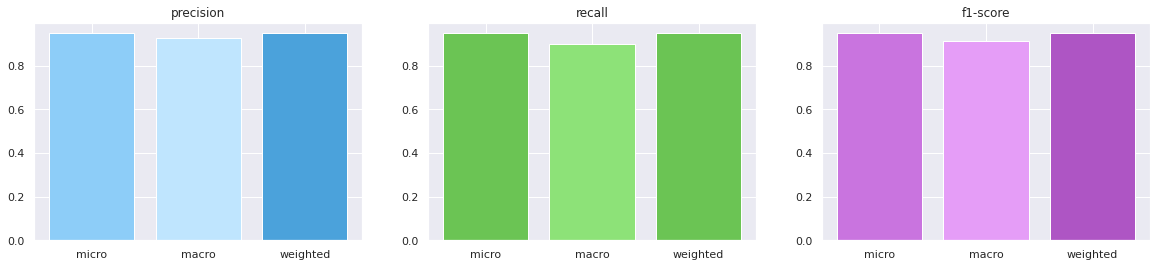

In [ ]:
print('RandomForestClassifier')
plot_metrics(RandomForestClassifier(), X_train4, X_test4, y_train4, y_test4)

**Вывод**: в этой части сначала запустил модели без изменений датасета, потом сделал стандартизацию, результаты чуть улучшились, дальше буду пытаться еще улучшить модели

### Выбрать метрику, которую нужно максимизировать. Перебрать гиперпараметры моделей

**Ответ**: Запустив модели, можно заметить, что accuracy, precision, recall, f1_score - примерно равны одному и тому же с параметрами "micro" и "weighted".

"macro" отличается, потому что этот параметр не учитывает дисбаланс классов, хоть он здесь и не такой огромный, как в датасете с мошенническими транзакциями, но все же дисбаланс есть

Поэтому в этом датасете можно было максимизировать и accuracy, и, например, f1_score, результаты исследования были бы хорошими, что не скажешь про мошеннические транзакции, там accuracy использовать для выводов не нужно. А вот в этом датасете попробую максимизировать **accuracy**

Будем пользоваться похожими методами, как в датасете с мошенническими транзакциями, а именно:
**Общий метод** - Для X сделал стандартизацию данных
- Для **LogisticRegression** пробую добавлять новые фичи в датасет, также с помощью GridsearchCV попробую перебрать гиперпараметры
- Для **KNeighborsClassifier** пробую добавлять новые фичи в датасет, также с помощью GridsearchCV попробую перебрать гиперпараметры
- Для **RandomForest** с помощью GridsearchCV попробую перебрать гиперпараметры

#### LogisticRegression

In [ ]:
model_improve(LogisticRegression(), X2, y2)


('uterine_contractions', 'abnormal_short_term_variability')
('histogram_min', 'histogram_mode')
('histogram_min', 'histogram_mean')
('histogram_median', 'histogram_tendency')
('histogram_mode', 'histogram_variance')


In [ ]:
X_new2 = X2
X_new2['uc_astv'] = X_new2['uterine_contractions'] * X_new2['abnormal_short_term_variability']
X_new2['hmin_hmode'] = X_new2['histogram_min'] * X_new2['histogram_mode']
X_new2['hmin_hmean'] = X_new2['histogram_min'] * X_new2['histogram_mean']
X_new2['hmed_ht'] = X_new2['histogram_median'] * X_new2['histogram_tendency']
X_new2['hmode_hvar'] = X_new2['histogram_mode'] * X_new2['histogram_variance']

In [ ]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X_new2, y2, test_size=0.2, random_state=42)

In [ ]:
accuracy(LogisticRegression(), X_train5, X_test5, y_train5, y_test5)

0.9014084507042254

Добавление фич в датасет заметно улучшило качество!

Теперь переберу некоторые гиперпараметры и попробую найти лучшие

In [ ]:
best_params_log(X_train5, y_train5, scoring='accuracy', solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])

The best parameters for using this model is {'C': 5, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
accuracy(LogisticRegression(C=5, class_weight=None, max_iter=100, penalty='l1', solver='liblinear'), X_train5, X_test5, y_train5, y_test5)

0.8943661971830986

Получается лучшие гиперпараметры остались изначальные

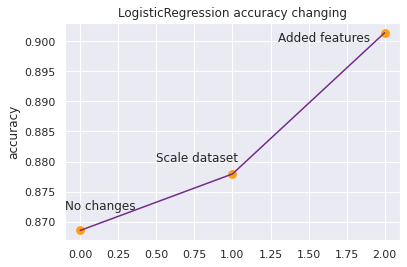

In [ ]:
plt.plot([accuracy(LogisticRegression(), X_tr, X_te, y_tr, y_te), accuracy(LogisticRegression(), X_train4, X_test4, y_train4, y_test4), 
          accuracy(LogisticRegression(), X_train5, X_test5, y_train5, y_test5)], color='#722B8B');
plt.ylabel('accuracy')
plt.title('LogisticRegression accuracy changing')
plt.scatter(0.0, accuracy(LogisticRegression(), X_tr, X_te, y_tr, y_te), color='#FE9F10', s=60, marker='o')
plt.scatter(1.0, accuracy(LogisticRegression(), X_train4, X_test4, y_train4, y_test4), color='#FE9F10', s=60, marker='o')
plt.scatter(2.0, accuracy(LogisticRegression(), X_train5, X_test5, y_train5, y_test5), color='#FE9F10', s=60, marker='o')
plt.text(-0.1, 0.872, 'No changes')
plt.text(0.5, 0.88, 'Scale dataset')
plt.text(1.3, 0.9, 'Added features');

**Вывод**: удалось улучшить accuracy c 0.87 до **0.9** после добавления фич

#### KNeighborsClassifier

Попробуем выявить наиболее сильную зависимость признаков между собой, а потом добавить объединить объединение некоторых фич

In [ ]:
X2 = X2.drop(['uc_astv', 'hmin_hmode', 'hmin_hmean', 'hmed_ht', 'hmode_hvar'], axis=1)

In [ ]:
model_improve(KNeighborsClassifier(), X2, y2)


('abnormal_short_term_variability', 'NEW')
('histogram_max', 'histogram_mean')
('histogram_max', 'histogram_median')
('histogram_median', 'NEW')
('histogram_mean', 'histogram_variance')


In [ ]:
X_new3 = X2
X_new3['hmax_hmean'] = X_new3['histogram_max'] * X_new3['histogram_mean']
X_new3['hmax_hmed'] = X_new3['histogram_max'] * X_new3['histogram_median']
X_new3['hmean_hned'] = X_new3['histogram_mean'] * X_new3['histogram_median']
X_new3['hmean_hvar'] = X_new3['histogram_mean'] * X_new3['histogram_variance']

In [ ]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(X_new3, y2, test_size=0.2, random_state=42)

In [ ]:
accuracy(KNeighborsClassifier(), X_train6, X_test6, y_train6, y_test6)

0.9131455399061033

Как видно, это не помогло модели  KNeighborsClassifier, в отличие от LogisticRegression

Теперь попробуем перебрать гиперпараметры с помощью GridSearchCV

In [ ]:
X_train7, X_test7, y_train7, y_test7 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [ ]:
param_grid = {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['minkowski', 'euclidean', 'manhattan']
            }

knn_cv = GridSearchCV(estimator = model_fit(KNeighborsClassifier(), X_train7, X_test7, y_train7, y_test7), param_grid = param_grid, scoring = 'accuracy', verbose = 10, n_jobs = -1)
knn_cv.fit(X_train7, y_train7)

best_parameters = knn_cv.best_params_
print("The best parameters for using this model is", best_parameters)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1935s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1787s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    3.4s


The best parameters for using this model is {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.6s finished


In [ ]:
accuracy(KNeighborsClassifier(n_neighbors=5, metric='manhattan', weights='distance'), X_train7, X_test7, y_train7, y_test7)

0.9225352112676056

Перебор гиперпараметров KNeighborsClassifier действительно помог! 

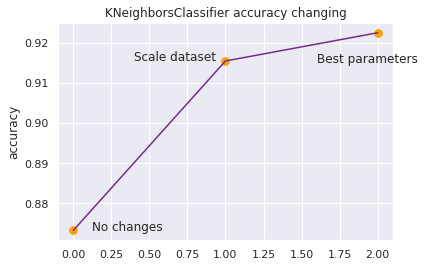

In [ ]:
plt.plot([accuracy(KNeighborsClassifier(), X_tr, X_te, y_tr, y_te), accuracy(KNeighborsClassifier(), X_train4, X_test4, y_train4, y_test4), 
          accuracy(KNeighborsClassifier(n_neighbors=5, metric='manhattan', weights='distance'), X_train7, X_test7, y_train7, y_test7)], color='#722B8B');
plt.ylabel('accuracy')
plt.title('KNeighborsClassifier accuracy changing')
plt.scatter(0.0, accuracy(KNeighborsClassifier(), X_tr, X_te, y_tr, y_te), color='#FE9F10', s=60, marker='o')
plt.scatter(1.0, accuracy(KNeighborsClassifier(), X_train4, X_test4, y_train4, y_test4), color='#FE9F10', s=60, marker='o')
plt.scatter(2.0, accuracy(KNeighborsClassifier(n_neighbors=5, metric='manhattan', weights='distance'), X_train7, X_test7, y_train7, y_test7), color='#FE9F10', s=60, marker='o')
plt.text(0.12, accuracy(KNeighborsClassifier(), X_tr, X_te, y_tr, y_te), 'No changes')
plt.text(0.4, accuracy(KNeighborsClassifier(), X_train4, X_test4, y_train4, y_test4), 'Scale dataset')
plt.text(1.6, 0.915, 'Best parameters');

**Вывод**: удалось улучшить accuracy c 0.915 до **0.923** после перебора гиперпараметров

#### RandomForest

In [ ]:
X3 = data.drop('fetal_health', axis=1)
y3 = data['fetal_health']

In [ ]:
X_train8, X_test8, y_train8, y_test8 = train_test_split(X3, y3, test_size=0.2, random_state=42)

In [ ]:
param_grid = {
            'n_estimators': [100,150, 200,500,700,900],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth' : [4,6,8,12,14,16],
            'criterion' :['gini', 'entropy'],
             }

rf_cv = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, scoring = 'accuracy', cv=5, verbose = 10, n_jobs = -1)
rf_cv.fit(X_train8, y_train8)

best_parameters = rf_cv.best_params_
print("The best parameters for using this model is", best_parameters)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1

The best parameters for using this model is {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 150}


In [ ]:
rf_best = RandomForestClassifier(n_estimators=150, max_features='sqrt', criterion='entropy', max_depth=12, random_state=42)
rf_best.fit(X_train8, y_train8)
y_pred8 = rf_best.predict(X_test8)
accuracy_score(y_test8, y_pred8)

0.9530516431924883

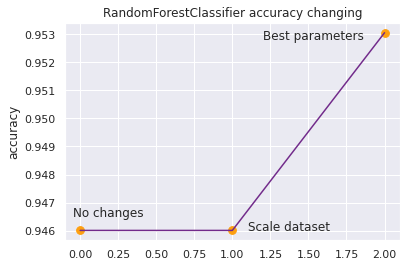

In [ ]:
plt.plot([accuracy(RandomForestClassifier(random_state=42), X_tr, X_te, y_tr, y_te), accuracy(RandomForestClassifier(random_state=42), X_train4, X_test4, y_train4, y_test4), 
          accuracy_score(y_test8, y_pred8)], color='#722B8B');
plt.ylabel('accuracy')
plt.title('RandomForestClassifier accuracy changing')
plt.scatter(0.0, accuracy(RandomForestClassifier(random_state=42), X_tr, X_te, y_tr, y_te), color='#FE9F10', s=60, marker='o')
plt.scatter(1.0, accuracy(RandomForestClassifier(random_state=42), X_train4, X_test4, y_train4, y_test4), color='#FE9F10', s=60, marker='o')
plt.scatter(2.0, accuracy_score(y_test8, y_pred8), color='#FE9F10', s=60, marker='o')
plt.text(-0.05, 0.9465, 'No changes')
plt.text(1.1, accuracy(RandomForestClassifier(random_state=42), X_train4, X_test4, y_train4, y_test4), 'Scale dataset')
plt.text(1.2, 0.9528, 'Best parameters');

### **Вывод**: Во всех трех моделях удалось улучшить качество accuracy, наилучший результат получился у RandomForest - **0.953**